In [2]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.stats import mode
import scipy.integrate as integrate
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.validation import check_is_fitted
from sklearn.cluster import SpectralClustering
from scipy.io import loadmat

import math
import random

#Please use in all section ex

Notes of debugging: 
- the generation of patterns works (macro, micro and spins works as expected).
- Ising_Setup working as expected.




# Derrida 1987 model definition

In [3]:
class Ising_setup(skl.base.BaseEstimator, skl.base.TransformerMixin):
    np.random.seed(117)
    def __init__(self,n_spins = 1000, sparsity = 2, p=2, overlap = 0.8, n_C = 6):

        self.n_spins = n_spins
        self.sparsity = sparsity
        self.n_C = n_C
        #np.ceil(np.log(n_spins)/sparsity).astype(int) #defined as in gardner, where C << logN
        self.p = p #number of patterns      
        #choose initial condition to align with one pattern (eg. 0.8 aligned)
        self.spins = (np.random.randint(2,size = (self.n_spins, 1))*2 -1).astype('int8') #initialize spin configuration, column vector
        self.overlap = overlap #quantify the amount of overal you want with the first pattern and the inital spins
    
    def getSpins(self):
        return self.spins
    
    def getConnectivity(self):
        return self.n_C
    
    def getPatterns(self):
        return self.p
    
    def getSparsity(self):
        return self.sparsity
    
    def randomPatterns(self):
        
        aligned_pattern = np.copy(self.spins).reshape(1,self.n_spins,1)
             
        pattern_tensor = np.tile(aligned_pattern,(1,1,self.p-1))
        
        #Microscopic alignment patterns (scale with sqrt(N))  
        for i in range(self.p-1):
            idx_no_align_micro = random.sample(range(self.n_spins),
                                               int((1-((self.overlap)/np.sqrt(self.n_spins)))*self.n_spins))            
            pattern_tensor[:,idx_no_align_micro,i] = aligned_pattern[:,idx_no_align_micro,0]*-1
               
        #aligned pattern (macroscopic: alignment not changing with N)        
        idx_no_align_macro = random.sample(range(self.n_spins),int((1-self.overlap)*self.n_spins))
        aligned_pattern[:,idx_no_align_macro,:] = aligned_pattern[:,idx_no_align_macro,:]*-1

        pattern_tensor_full = np.concatenate((aligned_pattern, pattern_tensor), axis = 2)

        return pattern_tensor_full[0,:,:].astype('int8')#, aligned_pattern


    def setConnectivity(self):

        C_mat = np.random.binomial(1, self.n_C/self.n_spins, (self.n_spins,self.n_spins))
        np.fill_diagonal(C_mat, 0)#no self connectivity in the model
        return C_mat
    
    def setWeights(self):

        
        pattern_matrix = self.randomPatterns() #matrix with each of the patterns (n_spins, n_patterns)
        interactions_across_patterns = pattern_matrix@pattern_matrix.T

        C_mat = self.setConnectivity().astype('int8') #connectivity matrix
        J_mat = np.multiply(C_mat, interactions_across_patterns)
        return J_mat, C_mat, interactions_across_patterns, pattern_matrix
        
    

# Model update and running

In [5]:
import math
import random


class Ising_run(skl.base.BaseEstimator, skl.base.TransformerMixin):
    np.random.seed(117)
    def __init__(self, spins, p, J, temperature = 0.01):
                
        self.temperature = temperature
        self.n_spins = spins.shape[0]
        #pattern matrix, each row corresponds to a pattern, first row being the one with macroscopic overlap
        self.p = p 
        self.spins = spins #initialize spin configuration (column vector)
        self.J = J #weight matrix
        self.field_matrix = J@spins
    
    def getSpins(self):
        return self.spins
    
    def getPatterns(self):
        return self.p

    def getTemperature(self):
        return self.temperature
    
    def updateField(self):
        self.field_matrix = self.J@self.spins        
    
    def getField(self):
        return self.field_matrix
    
    def getProbabilitySpin(self):
        '''
        Define the probability that the spin when updated equals +1, 1-prob = spin equals -1.
        '''
        prob = (1/(1+np.exp(-2*self.field_matrix/self.temperature))) #probability of having a 1
        #print("prob")
        #print(prob)
        return prob
    
    def updateSpin(self):
        '''
        Update spins based on field and the probability of the spin value
        '''

        spin_new = np.ones((self.n_spins,1))
        prob = self.getProbabilitySpin()
        rand_vals = np.random.uniform(0,1, self.n_spins) #if value is below prob, set spin to +1, else to -1
            
        for i in range(self.n_spins): 
            if rand_vals[i] > prob[i]:
                spin_new[i] = -1
        
        self.spins = spin_new.astype(np.int32)
    
    def magnetization(self):
        '''
        Calculate the averge mean field for each spin and average magnetizaiton
        
        '''
        #first pattern in the pattern matrix corresponds to the major overlap
        pattern_macro = self.p[:,0]
        
        individual_means = pattern_macro@self.spins
        magnetization = np.sum(individual_means)/self.n_spins
        
        return magnetization, individual_means, pattern_macro
    
        
    def simulateMeans(self,epochs):
        '''
        Run a simulation with a fixed temperature and capacity (alpha) for a certain amount of epochs
        '''
        #init_mag, init_means, p = self.magnetization()
        init_mag = np.sum(self.p[:,0]@self.spins)/self.n_spins
        means = [init_mag]

        for e in range(epochs):            
            T = self.temperature
            #print("spin_old")
            #print(self.spins)
            self.updateSpin()
            #print("spin_new")
            #print(self.spins)
            #new_mag, new_means, p = self.magnetization()
            new_mag = np.sum(self.p[:,0]@self.spins)/self.n_spins
            means.append(new_mag)
            #print("field_old")
            #print(self.field_matrix)
            self.updateField()
            #print("field_new")
            #print(self.field_matrix)
            print("Epoch " + str(e+1)+ "= " + str(new_mag) + " temp " + str(T))

        return means

# Define a model and test it

### Test block

In [ ]:
IS_s = Ising_setup(n_spins = 1000, p=3, overlap = 0.8, n_C = 100)
spins = IS_s.getSpins()
J = IS_s.setWeights()
C_mat = IS_s.setConnectivity()
C_constant = IS_s.getConnectivity()
p, aligned_pattern = IS_s.randomPatterns()

T = 0.01
IS_r = Ising_run(spins, p, J, temperature = 0.01)
magnetization, individual_means, pattern_macro = IS_r.magnetization()

means = IS_r.simulateMeans(10)

In [ ]:
plt.matshow(C_mat)

In [ ]:
plt.plot(means)
plt.title('Magnetization simulation (T = '+ str(T)+' and overlap = 0.8)')
plt.xlabel("time", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight')

# Analytical simulations

In [7]:
#Analytical update as in Derrida 1987

def analyticUpdate(m, a, T, epochs):
    '''
    Function takes the mean magnetization and returns a fixed temperature and capacity and returns the mean at the 
    next time step.
    '''
    
    f_m = [m]
   
    for e in range(epochs):
        
        g = lambda x: (np.exp(-x**2)*np.tanh((f_m[e]-x*np.sqrt(2*a))/T))/np.sqrt(np.pi) #euqation (18) in Derrida 1987 paper
        f = integrate.quad(g, -np.inf, np.inf)
        f_m.append(f[0])
        
    return f_m
    

# 1. Look at the effect of temperature in the analytic simulation and model

In [10]:
#critical value of temperature and capacity (f'(0) = 1)

def find_critical (t_range,a_range):
    
    f_m = np.zeros((t_range.shape[0],a_range.shape[0]))
    
    for i, t in enumerate(t_range):
        for j, a in enumerate(a_range):    
            g_prime = lambda x: (np.exp(-x**2)*np.tanh((1-x*np.sqrt(2*a))/t))**2/(np.sqrt(np.pi)*t)
            f = integrate.quad(g_prime, -np.inf, np.inf)
            f_m[i,j] = f[0]-1
    
    f_abs = np.abs(f_m)

    return f_abs
    

In [11]:
t_range = np.linspace(0.01, 1, 100)
a_range = np.linspace(0.01,1,100)

f_abs = find_critical(t_range,a_range)

(-0.0395, 1.0495, 0.526, 0.614)

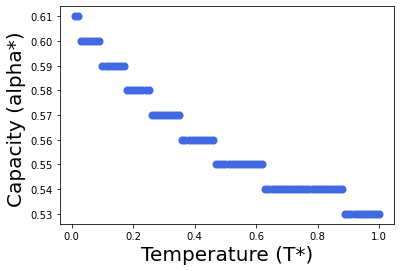

In [12]:
#plot analytic simulation results for varying temperatures    

critical_capacity = a_range[f_abs.argmin(0)]

plt.scatter(t_range, critical_capacity, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T*)", fontsize=20); 
plt.ylabel("Capacity (alpha*) ", fontsize=20);   plt.axis('tight')

# 2. Run analytic simulations for a given overlap and temperature

In [13]:
#run simulation for different temperatures and look at the last magnetization value for each simulation

def run_analytical_temp(t_array, epochs):
    '''
    Runs the simulation for parallel mean field updates with analytical equation 18 from Derrida.
    
    Arguments:
        t_array(np.array): array with the different temperature values
        epochs(int): number of epochs you want to run each individual simulation for
    '''
    magnetization = []
    stdev = []
    
    p = 2
    for t in t_array:
        IS = Ising(temperature = t)
        means = IS.simulateMeans(epochs)
        mean_means = np.mean(means)
        std = np.std(means)
        magnetization.append(mean_means)
        stdev.append(std)
        
    return magnetization, stdev

In [14]:
#run analytical simulation for different temperatures

a = 1/3
epochs = 100
t_array = np.linspace(0.001, 1, num = 100)
m = 0.6

end_m_t = []

for t in t_array:
    f_m = analyticUpdate(m, a, t, epochs)
    end_m_t.append(f_m[-1])
    

Text(0.5, 1.0, 'Capacity = 0.3333333333333333, m_0 = 0.6')

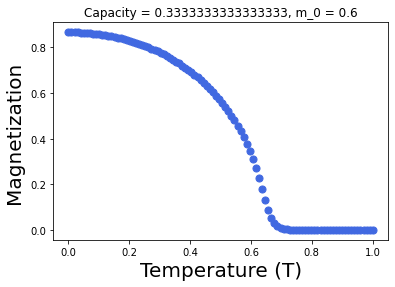

In [15]:
#plot analytic simulation results for varying temperatures    


plt.scatter(t_array, end_m_t, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight')
plt.title("Capacity = " +str(a)+ ", m_0 = " + str(m))


Text(0.5, 1.0, 'Capacity = 0.5, m_0 = 0.6')

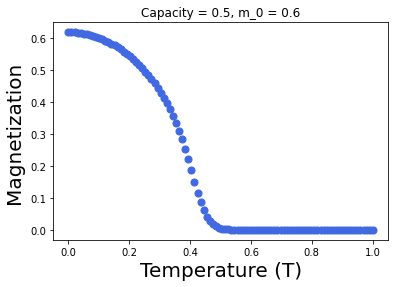

In [24]:
#plot analytic simulation results for varying temperatures    


plt.scatter(np.linspace(0.001, 1, num = 100), end_m_t, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight')
plt.title("Capacity = " +str(a)+ ", m_0 = " + str(m))

Text(0.5, 1.0, 'Capacity = 0.2, m_0 = 0.6')

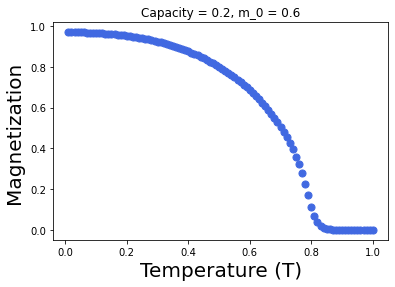

In [42]:
#plot analytic simulation results for varying temperatures    


plt.scatter(np.linspace(0.01, 1, num = 100), end_m_t, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight')
plt.title("Capacity = " +str(a)+ ", m_0 = " + str(m))

# 3. Analytical simulations for magnetizaiton as a funciton of capacity

In [10]:
#run analytical simulation for different capacity values

a_array = np.linspace(0.001, 1, num = 100)
epochs = 100
t = 0.01
m = 0.6

end_m_a = []

for a in a_array:
    f_m = analyticUpdate(m, a, t, epochs)
    end_m_a.append(f_m[-1])

(-0.04895, 1.04995, -0.04999999995332408, 1.0499999999977774)

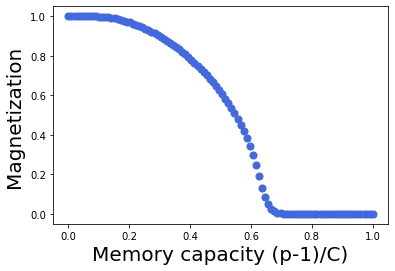

In [11]:
#plot analytic simulation results for varying alpha (memory capacity)   


plt.scatter(a_array, end_m_a, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Memory capacity (p-1)/C)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight')

# 4. Look at the effects of temperature and capacity on magnetization

### Model results: Compare with the analytical results

In [16]:
#run simulation for different temperatures and look at the last magnetization value for each simulation

#intially keep p and C constant (implies alpha constant)

def run_simulation_temp(n_spins, t_array, n_p, ov, C, epochs):
    '''
    Runs the simulation of parallel mean field updates.
    
    Arguments:
        n_spins(int): number of spins to have in the simulation
        t_array(np.array): array with the different temperature values
        C (float): value of the average degree of the graph
        n_p(int): number of patterns to store
        ov(float): number between 0 and 1 indicating the percent of overlap 
        epochs(int): number of epochs you want to run each individual simulation for
    
    '''
    magnetization = []
    stdev = []
    last_m = []
    IS_set = Ising_setup(n_spins = n_spins, p=n_p, overlap = ov, n_C = C)
    spins = IS_set.getSpins()
    J, C_mat, interactions_across_patterns,patterns = IS_set.setWeights()
    
    for t in t_array:
        print(t)
        
        IS_run = Ising_run(spins, patterns, J, temperature = t)
        means = IS_run.simulateMeans(epochs)
        mean_means = np.mean(means)
        std = np.std(means)
        
        magnetization.append(mean_means)
        stdev.append(std)
        last_m.append(means[-1])
        
    
    return magnetization, stdev, last_m      

In [22]:
#run simulation for different temperatures

t_array = np.linspace(0.001, 3.5, num = 10)
#t_array = [0.01]
n_spins = int(1e4)
epochs = 100
ov = 0.8

#makes alpha = (p-1)/C and divides the initial temperature t_array by C
C = 3
n_p = 2

magnetization, stdev, last_m = run_simulation_temp(n_spins, t_array, n_p, ov, C, epochs)

#run simulation for mean magnetization in time, not last time point
'''
magnetization, std = run_simulation_temp(t_array, epochs)
'''
        

0.001
Epoch 1= 0.6454 temp 0.001
Epoch 2= 0.6402 temp 0.001
Epoch 3= 0.636 temp 0.001
Epoch 4= 0.6372 temp 0.001
Epoch 5= 0.6182 temp 0.001
Epoch 6= 0.627 temp 0.001
Epoch 7= 0.6218 temp 0.001
Epoch 8= 0.6238 temp 0.001
Epoch 9= 0.6206 temp 0.001
Epoch 10= 0.622 temp 0.001
Epoch 11= 0.6092 temp 0.001
Epoch 12= 0.599 temp 0.001
Epoch 13= 0.6058 temp 0.001
Epoch 14= 0.6126 temp 0.001
Epoch 15= 0.6142 temp 0.001
Epoch 16= 0.6196 temp 0.001
Epoch 17= 0.609 temp 0.001
Epoch 18= 0.6108 temp 0.001
Epoch 19= 0.6196 temp 0.001
Epoch 20= 0.6176 temp 0.001
Epoch 21= 0.6108 temp 0.001
Epoch 22= 0.6142 temp 0.001
Epoch 23= 0.6126 temp 0.001
Epoch 24= 0.613 temp 0.001
Epoch 25= 0.6044 temp 0.001
Epoch 26= 0.5978 temp 0.001
Epoch 27= 0.5946 temp 0.001
Epoch 28= 0.6014 temp 0.001
Epoch 29= 0.6044 temp 0.001
Epoch 30= 0.6004 temp 0.001
Epoch 31= 0.604 temp 0.001
Epoch 32= 0.6028 temp 0.001
Epoch 33= 0.5944 temp 0.001
Epoch 34= 0.5942 temp 0.001
Epoch 35= 0.5862 temp 0.001
Epoch 36= 0.5856 temp 0.001
Ep

Epoch 34= 0.5954 temp 0.7785555555555556
Epoch 35= 0.611 temp 0.7785555555555556
Epoch 36= 0.5988 temp 0.7785555555555556
Epoch 37= 0.5996 temp 0.7785555555555556
Epoch 38= 0.5916 temp 0.7785555555555556
Epoch 39= 0.6058 temp 0.7785555555555556
Epoch 40= 0.5986 temp 0.7785555555555556
Epoch 41= 0.6012 temp 0.7785555555555556
Epoch 42= 0.5986 temp 0.7785555555555556
Epoch 43= 0.5994 temp 0.7785555555555556
Epoch 44= 0.607 temp 0.7785555555555556
Epoch 45= 0.5916 temp 0.7785555555555556
Epoch 46= 0.5894 temp 0.7785555555555556
Epoch 47= 0.5906 temp 0.7785555555555556
Epoch 48= 0.5908 temp 0.7785555555555556
Epoch 49= 0.584 temp 0.7785555555555556
Epoch 50= 0.5922 temp 0.7785555555555556
Epoch 51= 0.5802 temp 0.7785555555555556
Epoch 52= 0.5902 temp 0.7785555555555556
Epoch 53= 0.5972 temp 0.7785555555555556
Epoch 54= 0.6094 temp 0.7785555555555556
Epoch 55= 0.6066 temp 0.7785555555555556
Epoch 56= 0.6126 temp 0.7785555555555556
Epoch 57= 0.6036 temp 0.7785555555555556
Epoch 58= 0.6134 te

Epoch 36= 0.4804 temp 1.556111111111111
Epoch 37= 0.4904 temp 1.556111111111111
Epoch 38= 0.4894 temp 1.556111111111111
Epoch 39= 0.4776 temp 1.556111111111111
Epoch 40= 0.4838 temp 1.556111111111111
Epoch 41= 0.4832 temp 1.556111111111111
Epoch 42= 0.482 temp 1.556111111111111
Epoch 43= 0.4814 temp 1.556111111111111
Epoch 44= 0.4662 temp 1.556111111111111
Epoch 45= 0.4756 temp 1.556111111111111
Epoch 46= 0.4842 temp 1.556111111111111
Epoch 47= 0.4738 temp 1.556111111111111
Epoch 48= 0.4664 temp 1.556111111111111
Epoch 49= 0.4712 temp 1.556111111111111
Epoch 50= 0.4842 temp 1.556111111111111
Epoch 51= 0.4754 temp 1.556111111111111
Epoch 52= 0.4808 temp 1.556111111111111
Epoch 53= 0.4726 temp 1.556111111111111
Epoch 54= 0.4766 temp 1.556111111111111
Epoch 55= 0.4688 temp 1.556111111111111
Epoch 56= 0.4674 temp 1.556111111111111
Epoch 57= 0.4762 temp 1.556111111111111
Epoch 58= 0.4656 temp 1.556111111111111
Epoch 59= 0.469 temp 1.556111111111111
Epoch 60= 0.471 temp 1.556111111111111
Epo

Epoch 41= 0.157 temp 2.3336666666666663
Epoch 42= 0.1624 temp 2.3336666666666663
Epoch 43= 0.1672 temp 2.3336666666666663
Epoch 44= 0.1668 temp 2.3336666666666663
Epoch 45= 0.1488 temp 2.3336666666666663
Epoch 46= 0.1374 temp 2.3336666666666663
Epoch 47= 0.15 temp 2.3336666666666663
Epoch 48= 0.1486 temp 2.3336666666666663
Epoch 49= 0.147 temp 2.3336666666666663
Epoch 50= 0.1274 temp 2.3336666666666663
Epoch 51= 0.1124 temp 2.3336666666666663
Epoch 52= 0.103 temp 2.3336666666666663
Epoch 53= 0.0914 temp 2.3336666666666663
Epoch 54= 0.0978 temp 2.3336666666666663
Epoch 55= 0.094 temp 2.3336666666666663
Epoch 56= 0.099 temp 2.3336666666666663
Epoch 57= 0.0946 temp 2.3336666666666663
Epoch 58= 0.0882 temp 2.3336666666666663
Epoch 59= 0.0906 temp 2.3336666666666663
Epoch 60= 0.0684 temp 2.3336666666666663
Epoch 61= 0.0528 temp 2.3336666666666663
Epoch 62= 0.0544 temp 2.3336666666666663
Epoch 63= 0.0632 temp 2.3336666666666663
Epoch 64= 0.0626 temp 2.3336666666666663
Epoch 65= 0.0714 temp 2

Epoch 42= -0.0282 temp 3.111222222222222
Epoch 43= -0.0374 temp 3.111222222222222
Epoch 44= -0.0302 temp 3.111222222222222
Epoch 45= -0.0318 temp 3.111222222222222
Epoch 46= -0.0212 temp 3.111222222222222
Epoch 47= -0.027 temp 3.111222222222222
Epoch 48= -0.0212 temp 3.111222222222222
Epoch 49= -0.0426 temp 3.111222222222222
Epoch 50= -0.0286 temp 3.111222222222222
Epoch 51= -0.03 temp 3.111222222222222
Epoch 52= -0.015 temp 3.111222222222222
Epoch 53= 0.0136 temp 3.111222222222222
Epoch 54= 0.0042 temp 3.111222222222222
Epoch 55= -0.0266 temp 3.111222222222222
Epoch 56= -0.009 temp 3.111222222222222
Epoch 57= -0.0126 temp 3.111222222222222
Epoch 58= -0.0054 temp 3.111222222222222
Epoch 59= 0.0036 temp 3.111222222222222
Epoch 60= -0.0116 temp 3.111222222222222
Epoch 61= -0.007 temp 3.111222222222222
Epoch 62= -0.0082 temp 3.111222222222222
Epoch 63= -0.0084 temp 3.111222222222222
Epoch 64= -0.008 temp 3.111222222222222
Epoch 65= -0.0028 temp 3.111222222222222
Epoch 66= -0.0002 temp 3.1

'\nmagnetization, std = run_simulation_temp(t_array, epochs)\n'

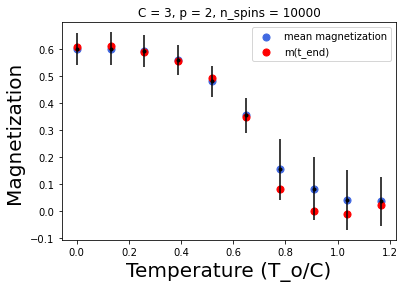

In [23]:
plt.scatter(t_array/C, magnetization, s=50, marker='o', color='RoyalBlue', label = 'mean magnetization')
plt.scatter(t_array/C, last_m, s=50, marker='o', color='red', label = 'm(t_end)')
plt.errorbar(t_array/C, magnetization, yerr=stdev, fmt='.k')
plt.xlabel("Temperature (T_o/C)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight')
plt.title("C = " +str(C) + ", p = "+str(n_p) +", n_spins = " +str(n_spins))
plt.legend()

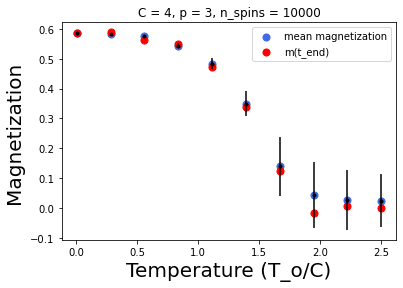

In [27]:
plt.scatter(t_array/C, magnetization, s=50, marker='o', color='RoyalBlue', label = 'mean magnetization')
plt.scatter(t_array/C, last_m, s=50, marker='o', color='red', label = 'm(t_end)')
plt.errorbar(t_array/C, magnetization, yerr=stdev, fmt='.k')
plt.xlabel("Temperature (T_o/C)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight')
plt.title("C = " +str(C) + ", p = "+str(n_p) +", n_spins = " +str(n_spins))
plt.legend()

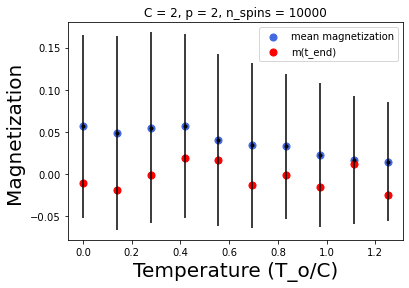

In [20]:
plt.scatter(t_array/C, magnetization, s=50, marker='o', color='RoyalBlue', label = 'mean magnetization')
plt.scatter(t_array/C, last_m, s=50, marker='o', color='red', label = 'm(t_end)')
plt.errorbar(t_array/C, magnetization, yerr=stdev, fmt='.k')
plt.xlabel("Temperature (T_o/C)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight')
plt.title("C = " +str(C) + ", p = "+str(n_p) +", n_spins = " +str(n_spins))
plt.legend()

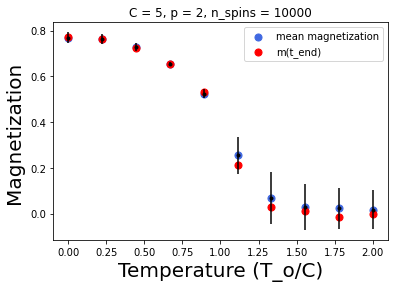

In [44]:
plt.scatter(t_array/C, magnetization, s=50, marker='o', color='RoyalBlue', label = 'mean magnetization')
plt.scatter(t_array/C, last_m, s=50, marker='o', color='red', label = 'm(t_end)')
plt.errorbar(t_array/C, magnetization, yerr=stdev, fmt='.k')
plt.xlabel("Temperature (T_o/C)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight')
plt.title("C = " +str(C) + ", p = "+str(n_p) +", n_spins = " +str(n_spins))
plt.legend()

# Testing block

In [10]:


epochs = 100
n_p = 3
C = 4
n_sp = 10000
ov = 0.8

IS_s = Ising_setup(n_spins = n_sp, p=n_p, overlap = ov, n_C = C)
spins = IS_s.getSpins()
J, C_mat, interactions_across_patterns, pattern_matrix = IS_s.setWeights()

t = 10
IS_r = Ising_run(spins, pattern_matrix, J, temperature = t)
means = IS_r.simulateMeans(epochs)
mean_means = np.mean(means)
std = np.std(means)



Epoch 1= 0.4772 temp 10
Epoch 2= 0.352 temp 10
Epoch 3= 0.244 temp 10
Epoch 4= 0.1926 temp 10
Epoch 5= 0.1686 temp 10
Epoch 6= 0.1252 temp 10
Epoch 7= 0.1078 temp 10
Epoch 8= 0.0768 temp 10
Epoch 9= 0.0386 temp 10
Epoch 10= 0.0182 temp 10
Epoch 11= 0.0138 temp 10
Epoch 12= 0.0094 temp 10
Epoch 13= -0.0044 temp 10
Epoch 14= 0.0192 temp 10
Epoch 15= 0.0126 temp 10
Epoch 16= 0.0044 temp 10
Epoch 17= 0.0058 temp 10
Epoch 18= -0.007 temp 10
Epoch 19= 0.001 temp 10
Epoch 20= 0.0124 temp 10
Epoch 21= 0.0156 temp 10
Epoch 22= 0.022 temp 10
Epoch 23= -0.0024 temp 10
Epoch 24= -0.0034 temp 10
Epoch 25= -0.0182 temp 10
Epoch 26= 0.0032 temp 10
Epoch 27= -0.023 temp 10
Epoch 28= -0.0092 temp 10
Epoch 29= -0.0138 temp 10
Epoch 30= -0.0256 temp 10
Epoch 31= -0.0242 temp 10
Epoch 32= 0.0004 temp 10
Epoch 33= -0.0134 temp 10
Epoch 34= -0.0076 temp 10
Epoch 35= -0.0096 temp 10
Epoch 36= -0.0158 temp 10
Epoch 37= -0.026 temp 10
Epoch 38= -0.0196 temp 10
Epoch 39= -0.0054 temp 10
Epoch 40= 0.0086 temp 10

In [ ]:

def run_simulation_cap(n_spins, t, p_array, ov, C, epochs):
    '''
    Runs the simulation of parallel mean field updates.
    
    Arguments:
        n_spins(int): number of spins to have in the simulation
        t_array(np.array): array with the different temperature values
        C (float): value of the average degree of the graph
        p_array(np.array): array with number of patterns to store
        ov(float): number between 0 and 1 indicating the percent of overlap 
        epochs(int): number of epochs you want to run each individual simulation for
    
    ''' 
    
    magnetization = []
    stdev = []
    last_m = []
    
    for n_p in p_array:
        print(n_p)
        
        IS_set = Ising_setup(n_spins = n_spins, p=n_p, overlap = ov, n_C = C)
        spins = IS_set.getSpins()
        J = IS_set.setWeights()
        patterns, aligned_pattern = IS_set.randomPatterns()
        
        IS_run = Ising_run(spins, patterns, J, temperature = t)
        means = IS_run.simulateMeans(epochs)
        mean_means = np.mean(means)
        std = np.std(means)
        
        magnetization.append(mean_means)
        stdev.append(std)
        last_m.append(means[-1])

    
    return magnetization, stdev, last_m

In [ ]:
#run simulation for different temperatures

n_spins = 10000
t = 0.05 #when divided by C, T = 0.01
p_array = np.linspace(2,6,5).astype(int) #ranges from 0.2 to 1 in capacity
ov = 0.8
C = 10
epochs = 100




magnetization_cap, stdev_cap, last_m_cap = run_simulation_cap(n_spins, t, p_array, ov, C, epochs)

In [ ]:
(p_array-1)/C

In [ ]:
plt.scatter((p_array-1)/C, magnetization_cap, s=50, marker='o', color='RoyalBlue', label = 'mean magnetization')
plt.scatter((p_array-1)/C, last_m_cap, s=50, marker='o', color='red', label = 'm(t_end)')
plt.errorbar((p_array-1)/C, magnetization_cap, yerr=stdev_cap, fmt='.k')
plt.xlabel("alpha ((p-1)/C)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight')
plt.legend()

In [ ]:
#run simulation for different capacities

n_spins = 10000
t = 0.01 #when divided by C, T = 0.01
p_array = np.linspace(2,101,100).astype(int) #ranges from 0.2 to 1 in capacity
ov = 0.8
C = 100
epochs = 100

magnetization_cap, stdev_cap, last_m_cap = run_simulation_cap(n_spins, t, p_array, ov, C, epochs)

plt.scatter((p_array-1)/C, magnetization_cap, s=50, marker='o', color='RoyalBlue', label = 'mean magnetization')
plt.scatter((p_array-1)/C, last_m_cap, s=50, marker='o', color='red', label = 'm(t_end)')
plt.errorbar((p_array-1)/C, magnetization_cap, yerr=stdev_cap, fmt='.k')
plt.xlabel("alpha ((p-1)/C)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight')
plt.legend()



# 5. Magnetization dynamics as a function of time

### Analytical simulations

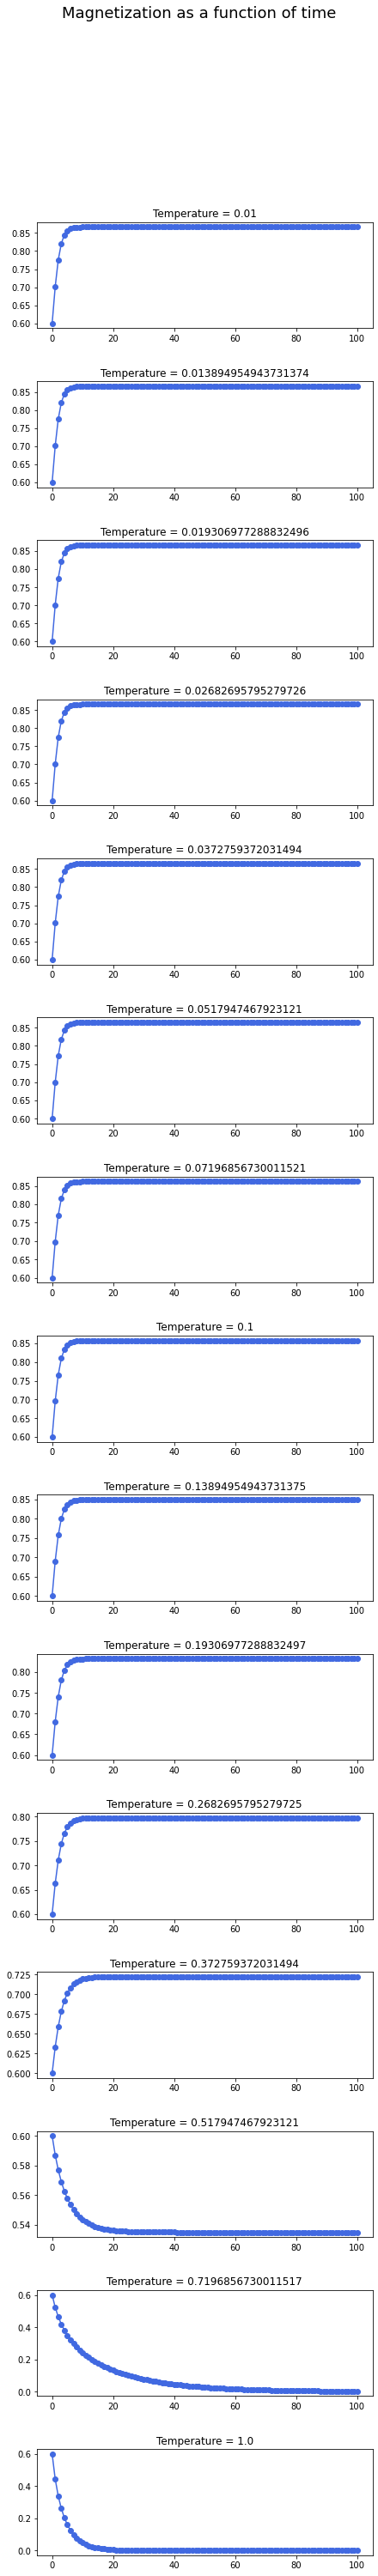

In [50]:
#Look at magnetization dynamics as a funciton of time (with alpha = 0.5 and inital mean of 0.6)
n_t = 15
temp = np.logspace(-2,0,n_t)
alpha = 1/3
m = 0.6
epochs = 100
time = np.linspace(0, epochs, epochs+1)

fig, ax = plt.subplots(nrows=n_t, ncols=1, figsize=(7, 50))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Magnetization as a function of time", fontsize=18, y=0.95)

for i, t in enumerate(temp):    
    fm_analytic = analyticUpdate(m, alpha, t, epochs)
    ax[i].plot(time, fm_analytic, marker='o', color='RoyalBlue')
    ax[i].title.set_text("Temperature = "+str(t))

    

    

### Model simulation

In [ ]:
C = 3
n_t = 10 # number of time points
#temp = np.logspace(-2,1,10)/C
temp = np.linspace(0.01,2,n_t)
n_spins = 100000
n_p = 2
ov = 0.8
epochs = 100
time = np.linspace(0, epochs, epochs+1)

fig, ax = plt.subplots(nrows=n_t, ncols=1, figsize=(7, 50))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Magnetization as a function of time", fontsize=18, y=0.95)

for i, t in enumerate(temp):  

    IS_set = Ising_setup(n_spins = n_spins, p=n_p, overlap = ov, n_C = C)
    spins = IS_set.getSpins()
    J, C_mat, interactions_across_patterns,patterns = IS_set.setWeights()
    IS_run = Ising_run(spins, patterns, J, temperature = t)
    fm_sim = IS_run.simulateMeans(epochs)
    
    ax[i].plot(time, fm_sim, color='RoyalBlue')
    ax[i].title.set_text("Temperature = "+str(t))


# 6. Overlay of analytical and model simulation

Epoch 1= 0.6408 temp 0.03
Epoch 2= 0.6488 temp 0.03
Epoch 3= 0.6486 temp 0.03
Epoch 4= 0.6538 temp 0.03
Epoch 5= 0.6446 temp 0.03
Epoch 6= 0.646 temp 0.03
Epoch 7= 0.6302 temp 0.03
Epoch 8= 0.6384 temp 0.03
Epoch 9= 0.6298 temp 0.03
Epoch 10= 0.6254 temp 0.03
Epoch 11= 0.6208 temp 0.03
Epoch 12= 0.607 temp 0.03
Epoch 13= 0.6012 temp 0.03
Epoch 14= 0.6052 temp 0.03
Epoch 15= 0.6132 temp 0.03
Epoch 16= 0.6168 temp 0.03
Epoch 17= 0.6236 temp 0.03
Epoch 18= 0.6252 temp 0.03
Epoch 19= 0.6294 temp 0.03
Epoch 20= 0.6346 temp 0.03
Epoch 21= 0.6272 temp 0.03
Epoch 22= 0.6222 temp 0.03
Epoch 23= 0.6212 temp 0.03
Epoch 24= 0.6196 temp 0.03
Epoch 25= 0.6222 temp 0.03
Epoch 26= 0.632 temp 0.03
Epoch 27= 0.639 temp 0.03
Epoch 28= 0.6336 temp 0.03
Epoch 29= 0.6236 temp 0.03
Epoch 30= 0.6174 temp 0.03
Epoch 31= 0.6244 temp 0.03
Epoch 32= 0.63 temp 0.03
Epoch 33= 0.6274 temp 0.03
Epoch 34= 0.6312 temp 0.03
Epoch 35= 0.6304 temp 0.03
Epoch 36= 0.6324 temp 0.03
Epoch 37= 0.6312 temp 0.03
Epoch 38= 0.6334

Epoch 37= 0.5598 temp 1.3566666666666667
Epoch 38= 0.5648 temp 1.3566666666666667
Epoch 39= 0.5488 temp 1.3566666666666667
Epoch 40= 0.5586 temp 1.3566666666666667
Epoch 41= 0.5474 temp 1.3566666666666667
Epoch 42= 0.5378 temp 1.3566666666666667
Epoch 43= 0.5298 temp 1.3566666666666667
Epoch 44= 0.5414 temp 1.3566666666666667
Epoch 45= 0.5494 temp 1.3566666666666667
Epoch 46= 0.5456 temp 1.3566666666666667
Epoch 47= 0.552 temp 1.3566666666666667
Epoch 48= 0.5552 temp 1.3566666666666667
Epoch 49= 0.5504 temp 1.3566666666666667
Epoch 50= 0.5446 temp 1.3566666666666667
Epoch 51= 0.5386 temp 1.3566666666666667
Epoch 52= 0.5456 temp 1.3566666666666667
Epoch 53= 0.5528 temp 1.3566666666666667
Epoch 54= 0.5456 temp 1.3566666666666667
Epoch 55= 0.5378 temp 1.3566666666666667
Epoch 56= 0.539 temp 1.3566666666666667
Epoch 57= 0.5522 temp 1.3566666666666667
Epoch 58= 0.557 temp 1.3566666666666667
Epoch 59= 0.5564 temp 1.3566666666666667
Epoch 60= 0.5536 temp 1.3566666666666667
Epoch 61= 0.5432 te

Epoch 73= 0.0304 temp 2.6833333333333336
Epoch 74= 0.0224 temp 2.6833333333333336
Epoch 75= 0.0066 temp 2.6833333333333336
Epoch 76= -0.0114 temp 2.6833333333333336
Epoch 77= -0.0088 temp 2.6833333333333336
Epoch 78= 0.0152 temp 2.6833333333333336
Epoch 79= 0.0404 temp 2.6833333333333336
Epoch 80= 0.027 temp 2.6833333333333336
Epoch 81= 0.038 temp 2.6833333333333336
Epoch 82= 0.0438 temp 2.6833333333333336
Epoch 83= 0.0534 temp 2.6833333333333336
Epoch 84= 0.043 temp 2.6833333333333336
Epoch 85= 0.052 temp 2.6833333333333336
Epoch 86= 0.0564 temp 2.6833333333333336
Epoch 87= 0.0658 temp 2.6833333333333336
Epoch 88= 0.057 temp 2.6833333333333336
Epoch 89= 0.05 temp 2.6833333333333336
Epoch 90= 0.0636 temp 2.6833333333333336
Epoch 91= 0.0792 temp 2.6833333333333336
Epoch 92= 0.0756 temp 2.6833333333333336
Epoch 93= 0.0716 temp 2.6833333333333336
Epoch 94= 0.1004 temp 2.6833333333333336
Epoch 95= 0.0884 temp 2.6833333333333336
Epoch 96= 0.0794 temp 2.6833333333333336
Epoch 97= 0.0672 temp

Epoch 8= 0.0584 temp 4.673333333333334
Epoch 9= 0.0138 temp 4.673333333333334
Epoch 10= 0.007 temp 4.673333333333334
Epoch 11= 0.0002 temp 4.673333333333334
Epoch 12= 0.0154 temp 4.673333333333334
Epoch 13= 0.0064 temp 4.673333333333334
Epoch 14= 0.0136 temp 4.673333333333334
Epoch 15= 0.0068 temp 4.673333333333334
Epoch 16= -0.0082 temp 4.673333333333334
Epoch 17= 0.0096 temp 4.673333333333334
Epoch 18= 0.0058 temp 4.673333333333334
Epoch 19= 0.0086 temp 4.673333333333334
Epoch 20= 0.0068 temp 4.673333333333334
Epoch 21= -0.0074 temp 4.673333333333334
Epoch 22= -0.007 temp 4.673333333333334
Epoch 23= -0.0058 temp 4.673333333333334
Epoch 24= 0.0072 temp 4.673333333333334
Epoch 25= 0.0074 temp 4.673333333333334
Epoch 26= -0.0102 temp 4.673333333333334
Epoch 27= -0.0182 temp 4.673333333333334
Epoch 28= -0.009 temp 4.673333333333334
Epoch 29= -0.005 temp 4.673333333333334
Epoch 30= -0.0004 temp 4.673333333333334
Epoch 31= -0.0094 temp 4.673333333333334
Epoch 32= -0.0136 temp 4.67333333333

Epoch 19= -0.0294 temp 6.0
Epoch 20= -0.0172 temp 6.0
Epoch 21= 0.0126 temp 6.0
Epoch 22= 0.0066 temp 6.0
Epoch 23= 0.0032 temp 6.0
Epoch 24= -0.0038 temp 6.0
Epoch 25= 0.005 temp 6.0
Epoch 26= -0.0108 temp 6.0
Epoch 27= -0.0138 temp 6.0
Epoch 28= -0.0142 temp 6.0
Epoch 29= -0.0032 temp 6.0
Epoch 30= 0.0116 temp 6.0
Epoch 31= -0.0026 temp 6.0
Epoch 32= -0.0162 temp 6.0
Epoch 33= -0.0086 temp 6.0
Epoch 34= -0.0196 temp 6.0
Epoch 35= 0.0006 temp 6.0
Epoch 36= -0.0074 temp 6.0
Epoch 37= -0.0076 temp 6.0
Epoch 38= -0.018 temp 6.0
Epoch 39= 0.0 temp 6.0
Epoch 40= 0.0004 temp 6.0
Epoch 41= 0.013 temp 6.0
Epoch 42= 0.0144 temp 6.0
Epoch 43= 0.0032 temp 6.0
Epoch 44= 0.0016 temp 6.0
Epoch 45= -0.0068 temp 6.0
Epoch 46= -0.018 temp 6.0
Epoch 47= -0.0026 temp 6.0
Epoch 48= -0.0128 temp 6.0
Epoch 49= -0.006 temp 6.0
Epoch 50= -0.0152 temp 6.0
Epoch 51= -0.009 temp 6.0
Epoch 52= -0.0182 temp 6.0
Epoch 53= -0.0058 temp 6.0
Epoch 54= -0.0096 temp 6.0
Epoch 55= 0.0002 temp 6.0
Epoch 56= 0.0008 temp 6

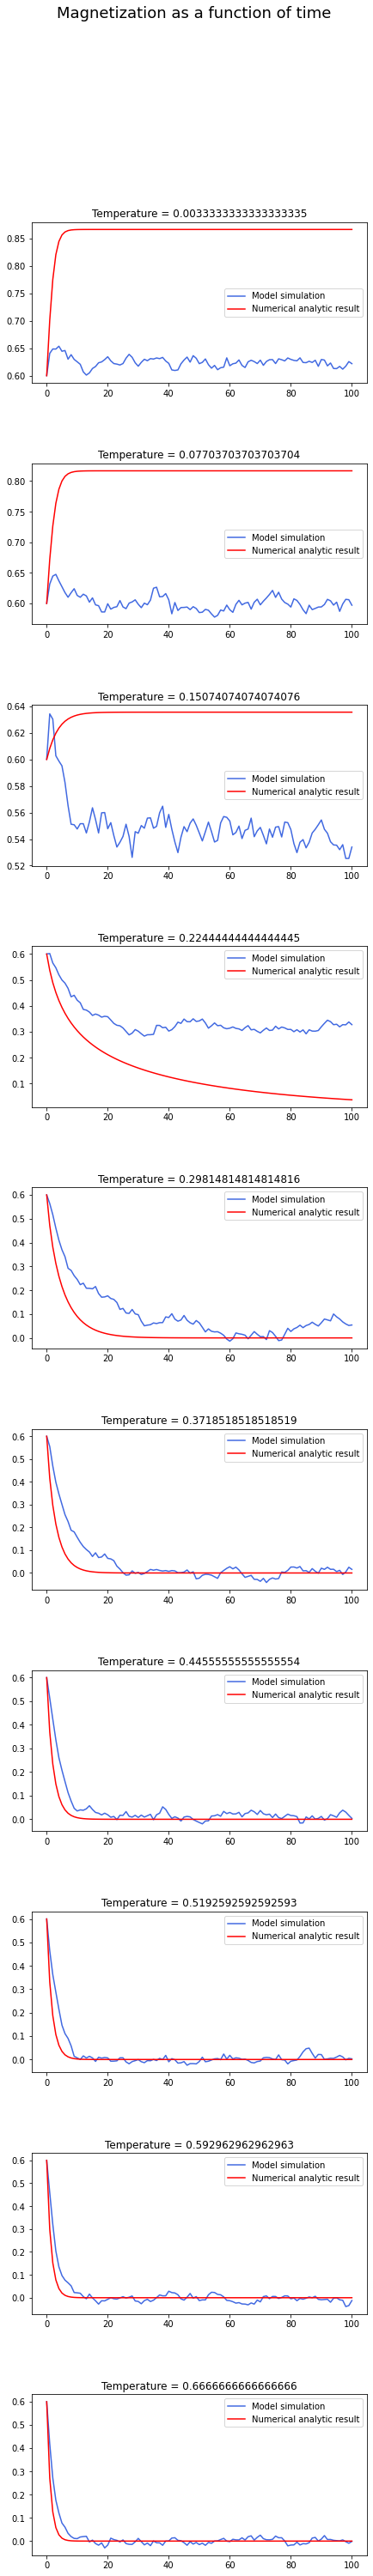

In [18]:


C = 3
n_t = 10 # number of time points
#temp = np.logspace(-2,1,10)/C
temp = np.linspace(0.01,2,n_t)
n_spins = 10000
n_p = 2

alpha = (n_p-1)/C
ov = 0.8
m = 1-2*(1-ov)
epochs = 100
time = np.linspace(0, epochs, epochs+1)

fig, ax = plt.subplots(nrows=n_t, ncols=1, figsize=(7, 50))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Magnetization as a function of time", fontsize=18, y=0.95)

for i, t in enumerate(temp):  

    IS_set = Ising_setup(n_spins = n_spins, p=n_p, overlap = ov, n_C = C)
    spins = IS_set.getSpins()
    J, C_mat, interactions_across_patterns,patterns = IS_set.setWeights()
    IS_run = Ising_run(spins, patterns, J, temperature = t*C)
    fm_sim = IS_run.simulateMeans(epochs)
    
    fm_analytic = analyticUpdate(m, alpha, t, epochs)
    
    ax[i].plot(time, fm_sim, color='RoyalBlue')
    ax[i].plot(time, fm_analytic, color='r')
    ax[i].legend(['Model simulation', 'Numerical analytic result'])
    ax[i].title.set_text("Temperature = "+str(t/C))

   
